# Practical work 8: Color quantification and search by content


In this practical work session, we will:

- Develop a color based descriptor that can be applied to every image in a database
- Use this color descriptor to create a method that searches images by content: the goal is to find the images that are the most similar to a query.

In [1]:
# Load useful library

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import scipy.ndimage
from skimage.color import rgb2hsv, hsv2rgb

# Usefull functions
def setColors(nH, nS, nV):
    """ int**3 -> Array[nH*nS*nV,3]*Array[nH,nS,nV,3]
        computes an RGB palette from a sampling of HSV values
    """
    pal1 = np.zeros((nH*nS*nV, 3))
    pal2 = np.zeros((nH, nS, nV, 3))
    tH, tS, tV = 1/(2*nH), 1/(2*nS), 1/(2*nV)

    idx = 0
    for i in range(nH):
        for j in range(nS):
            for k in range(nV):
                HSVval = np.array([[[i/nH + tH, j/nS + tS, k/nV + tV]]])
                pal1[idx, :] = hsv2rgb(HSVval)*255  
                pal2[i, j, k, :] = hsv2rgb(HSVval)*255
                idx += 1
    return pal1, pal2

def viewQuantizedImage(I,pal):
    """ Array*Array -> Array
        Display an indexed image with colors according to pal 
    """
    Iview = np.empty(I.shape)
    n, m, c = I.shape
    for i in range(n):
        for j in range(m):
            h, s, v = I[i, j, :]
            Iview[i, j, :] = pal[ np.int(h), np.int(s), np.int(v), :]
    print( Iview.max())
    plt.imshow(Iview/255)
    plt.show()

def display5mainColors(histo, pal):
    """ Array*Array -> NoneType
        Display the 5 main colors in histo 
    """
    idx = np.argsort(histo)
    idx = idx[::-1]
    K = 5
    for i in range (K):
        Ia = np.zeros((1, 1, 3), dtype=np.uint8)
        Ia[0,0,0] = pal[idx[i], 0]
        Ia[0,0,1] = pal[idx[i], 1]
        Ia[0,0,2] = pal[idx[i], 2]
        plt.subplot(1, K, i+1)
        plt.imshow(Ia)
        plt.axis('off')
    plt.show()

def display20bestMatches(S, indexQuery):
    """ Array*int -> NoneType 
    """
    L = S[indexQuery, :]
    Idx = np.argsort(L)
    cpt = 1
    plt.figure(figsize=(15, 10))
    for idx in Idx[:20]:
        plt.subplot(5, 4, cpt)
        indexQuery = idx
        imageName = (pathImage+listImage[indexQuery]).strip()
        plt.imshow(np.array(Image.open(imageName))/255.)
        plt.title(listImage[indexQuery])
        plt.axis('off')
        cpt += 1
    plt.show()
    
def imshow(I, title=None, size=300, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

## Exercise 1: HSV histogram computation

Each image of the base will be represented by its color histogram in the HSV representation. We use the HSV representation rather than the RGB representation because it is a perceptual color space: two colors that look similar will have close HSV vectors.

1) Write a function ```iv = quantize(v,K)``` that returns the quantized interval of `v` considering a uniform quantization of values over the range $[0,1]$ with `K` evenly spaced intervals. For an image value v=1, the function will return K-1.

In [2]:
from math import *

def quantize(I, k):
    """ float*int -> int 
    """
    if I == 1:
        return k-1
    else:
        return int(I * k)

# You can test your function with the following lines:
h = np.zeros((8))
for i in range(256):
    h[quantize(i/255.,8)] += 1
assert (h == 32*np.ones((8))).all()

2) Write a function ```[Iq, histo] = quantizeImage(I,Nh,Ns,Nv)``` that takes as input one image I of size N x M x 3 in the HSV representation and the number of quantification interval needed for H, S and V. 
    Your function will return: 
 *    ```Iq```: the quantified image for each channel, of size N x M x 3
 *   ```hist```: a 3D histogram of size Nh x Ns x Nv that counts the number of pixels for each quantification bin (iH, iS, iV)

In [3]:
def quantizeImage(I, nH, nS, nV):
    """ Array*int -> Array*Array
    """
    Iq = np.zeros((I.shape)).astype(int)
    for i in range (Iq.shape[0]):
        for j in range (Iq.shape[1]):
            Iq[i,j,0] = quantize(I[i,j,0], nH)
            Iq[i,j,1] = quantize(I[i,j,1], nS)
            Iq[i,j,2] = quantize(I[i,j,2], nV)
    
    hist = np.zeros((nH, nS, nV))
    
    for i in range(Iq.shape[0]):
        for j in range(Iq.shape[1]):
            hist[Iq[i,j,0], Iq[i,j,1], Iq[i,j,2]] += 1
            
    return Iq, hist

3) Write a function ```normalized_histo = NormalizeHistL2(histo)``` that applies a normalization on the histogram ```histo``` according to the L2 norm.
The L2 norm of x can be computed using the function ```numpy.linalg.norm(x,2)```



In [4]:
def normalize(H):
    """ Array -> Array"""
    return H/np.linalg.norm(H,2)

4) Test the HSV histogram on an image: Complete the following code with your functions in order to apply it on one of the images of the base. The code will follow the following steps:
   1. Open the image and convert it into HSV representation.
   2. Compute the color palette for the display using the given ```setColors(nH, nS, nV)``` function.
   3. Compute the quantization of the image then visualize the quantized image using ```viewQuantizedImage(I,pal) ```.
   4. Transform the 3D histogram into a 1D histogram, normalize it according to L2 norm then visualize it.
   5. Display the 5 most prevalent colors on the image using ```display5mainColors(histo, pal)```.

   You can try this on the image ```Paysages67.png```with ```nH = 12```, ```nS = 3```  and ```nV = 8``` and find a result similar to Figures 1, 2, 3, and 4.

![figure1](./figs/Figure_1.png)
<center>Figure 1: Paysage67.png</center>

![figure2](./figs/Figure_2.png)
<center>Figure 2: Paysage67.png quantized</center>

![figure3](./figs/Figure_3.png)
<center>Figure 3: Histogram of HSV image (288 bins)</center>

![figure4](./figs/Figure_4.png)
<center>Figure 4: 5 main colors</center>


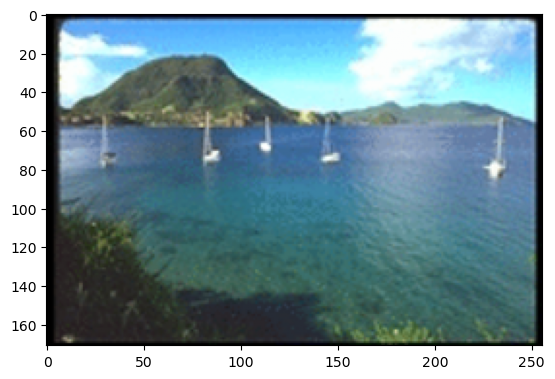

C:\Users\conmy\AppData\Local\Temp\ipykernel_44272\1353218900.py:38: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Iview[i, j, :] = pal[ np.int(h), np.int(s), np.int(v), :]


239.0625


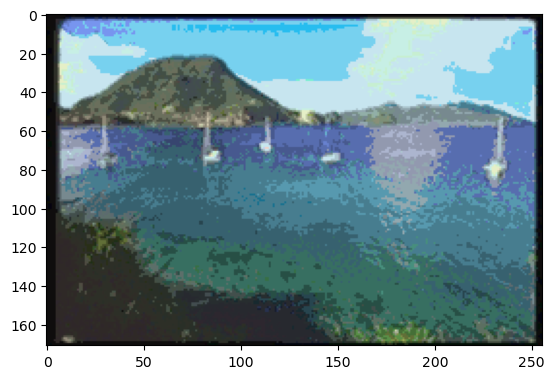

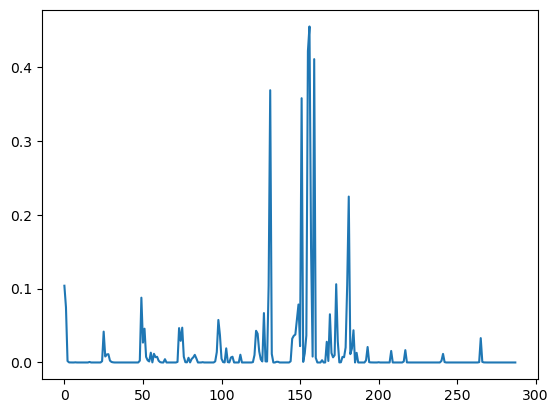

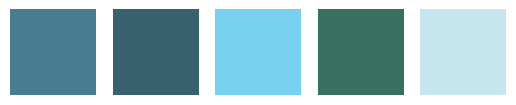

[(6, 1, 4), (6, 1, 3), (6, 1, 7), (5, 1, 3), (6, 0, 7)]


In [5]:
PathImage = './Base/'
nom = 'Paysages67.png'

# quantization parameters
nH = 12
nS = 3
nV = 8


filename = nom;
I = np.array(Image.open(PathImage + filename))
I = I / 255.  # I values range in [0,1]
plt.figure();
plt.imshow(I);
plt.show()

# conversion RGB->HSV
J = rgb2hsv(I)

# color palette computation
palette, palette2 = setColors( nH, nS , nV );

# Image quantization (your function)
Iq, histo = quantizeImage(J, nH, nS, nV)

# Visualisation of quantized image
viewQuantizedImage(Iq , palette2)

# flat a 3D histogram to 1D
histo = histo.flat

# Histogram normalization (your function)
histo = normalize(histo)

plt.figure()
plt.plot(histo)
plt.show()

## Determine 5 more frequent colors
idx_most_prevalent = (-histo).argsort()[:5]
hsv_most_prevalent = [np.unravel_index(idx,( nH, nS , nV )) for idx in idx_most_prevalent]

display5mainColors(histo, palette)

print(hsv_most_prevalent)

5) Change the values of ```nH```, ```nS```  and ```nV``` and analyze the results. You can try with other images in the base.

In [6]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define the function to use many times
def process_image(PathImage, nom, nH, nS, nV):
    filename = nom
    I = np.array(Image.open(PathImage + filename))
    I = I / 255.  # I values range in [0,1]

    plt.figure()
    plt.imshow(I)
    plt.show()

    # conversion RGB->HSV
    J = rgb2hsv(I)

    # color palette computation
    palette, palette2 = setColors(nH, nS, nV)

    # Image quantization (your function)
    Iq, histo = quantizeImage(J, nH, nS, nV)

    # Visualisation of quantized image
    viewQuantizedImage(Iq, palette2)

    # flat a 3D histogram to 1D
    histo = histo.flat

    # Histogram normalization (your function)
    histo = normalize(histo)

    plt.figure()
    plt.plot(histo)
    plt.show()

    # Determine 5 more frequent colors
    idx_most_prevalent = (-histo).argsort()[:5]
    hsv_most_prevalent = [np.unravel_index(idx, (nH, nS, nV)) for idx in idx_most_prevalent]

    display5mainColors(histo, palette)

    return hsv_most_prevalent

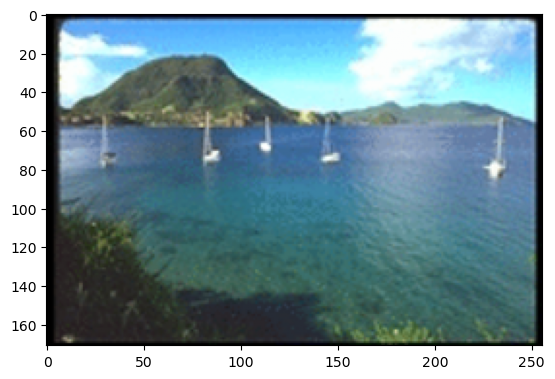

C:\Users\conmy\AppData\Local\Temp\ipykernel_44272\1353218900.py:38: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Iview[i, j, :] = pal[ np.int(h), np.int(s), np.int(v), :]


239.0625


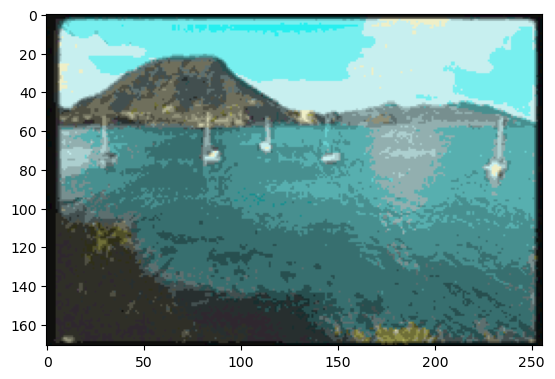

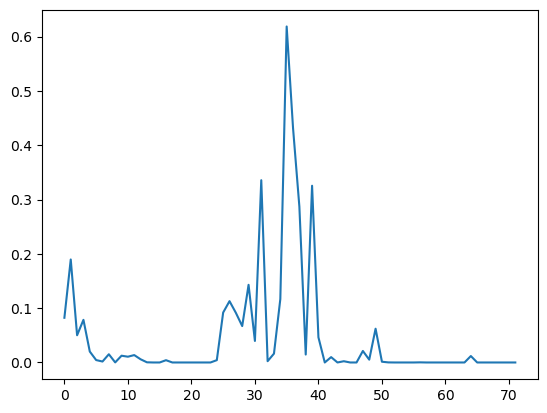

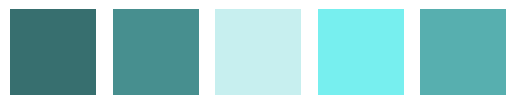

[(1, 1, 3), (1, 1, 4), (1, 0, 7), (1, 1, 7), (1, 1, 5)]


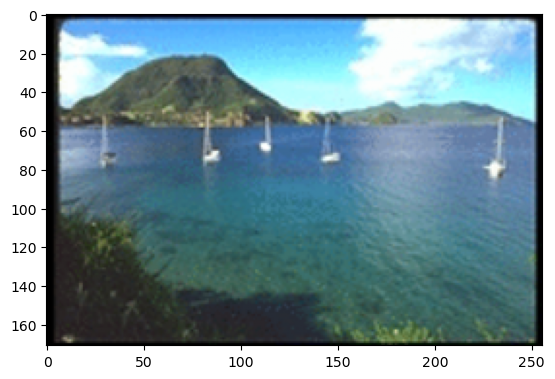

212.49999999999997


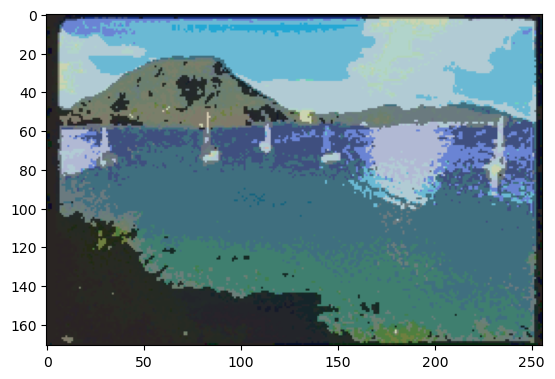

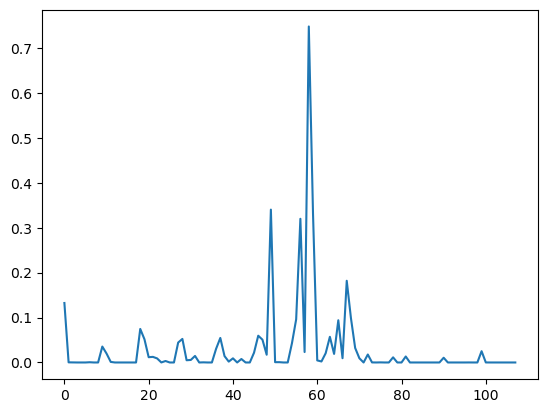

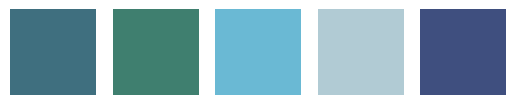

[(6, 1, 1), (5, 1, 1), (6, 1, 2), (6, 0, 2), (7, 1, 1)]


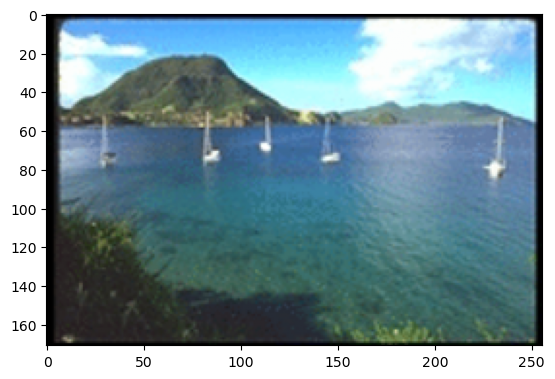

239.0625


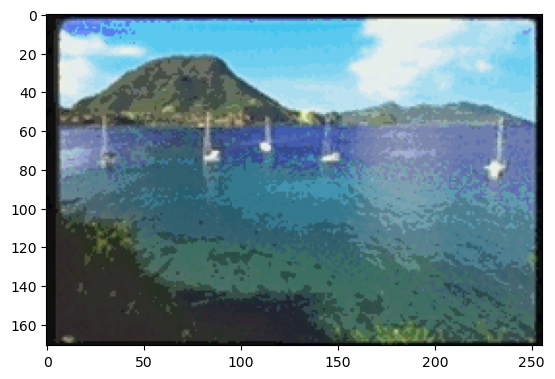

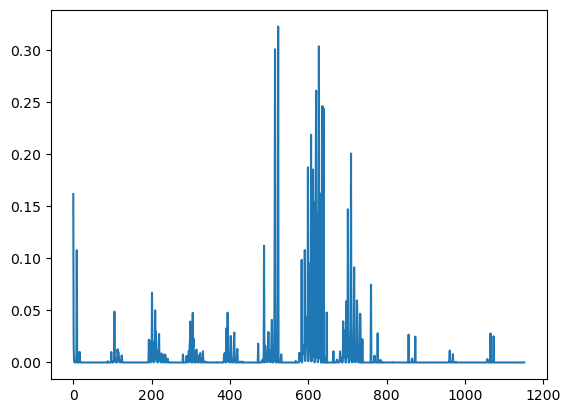

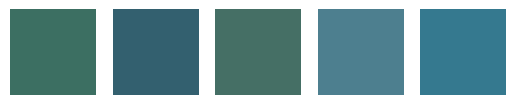

[(5, 5, 3), (6, 6, 3), (5, 4, 3), (6, 5, 4), (6, 7, 4)]


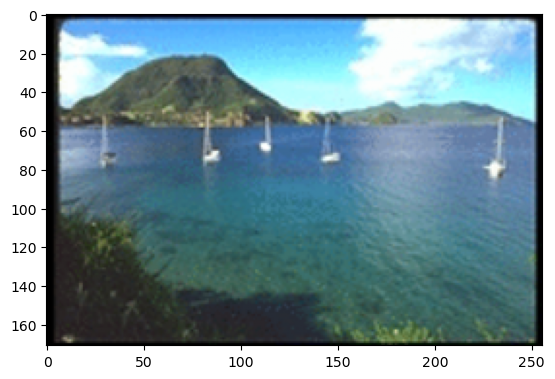

248.625


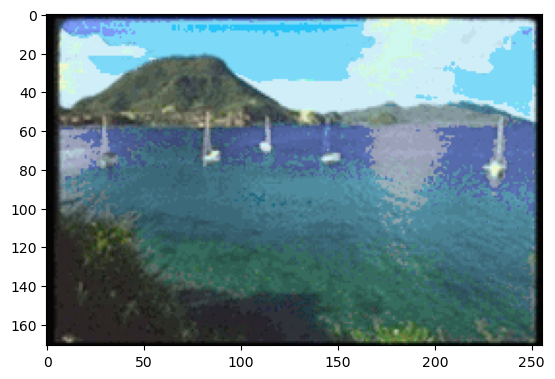

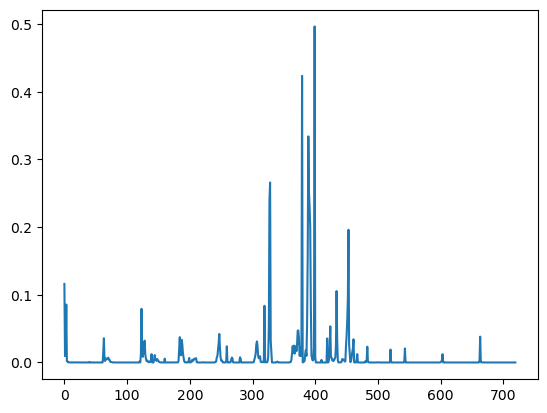

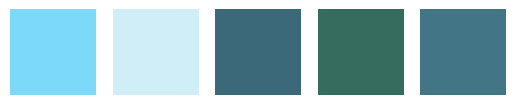

[(6, 1, 19), (6, 0, 19), (6, 1, 9), (5, 1, 8), (6, 1, 10)]


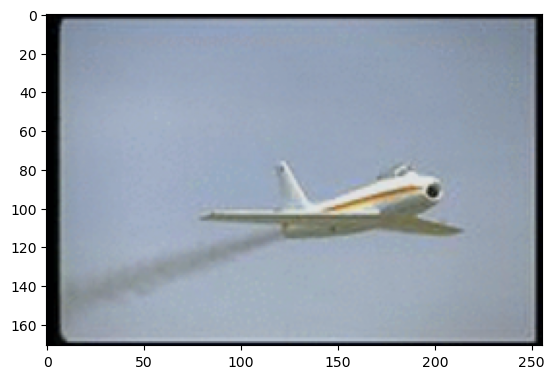

239.0625


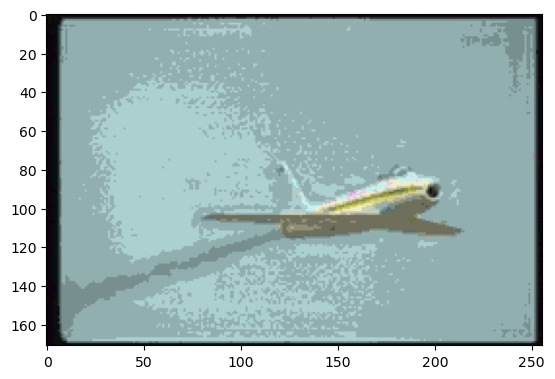

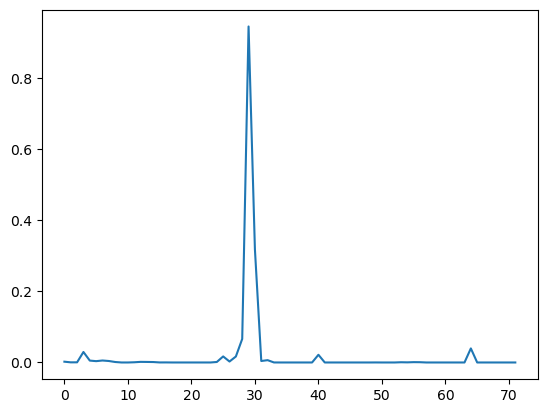

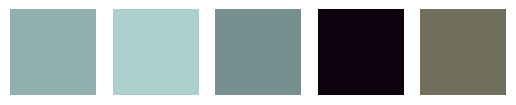

[(1, 0, 5), (1, 0, 6), (1, 0, 4), (2, 2, 0), (0, 0, 3)]


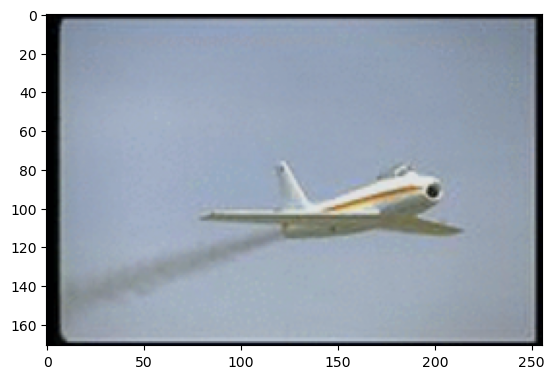

212.49999999999997


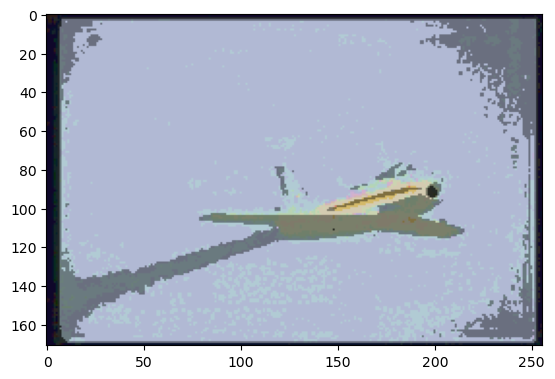

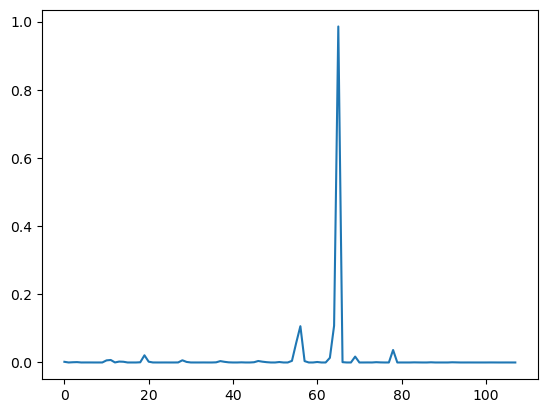

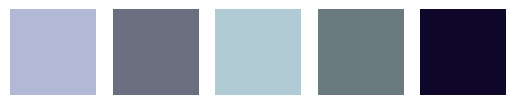

[(7, 0, 2), (7, 0, 1), (6, 0, 2), (6, 0, 1), (8, 2, 0)]


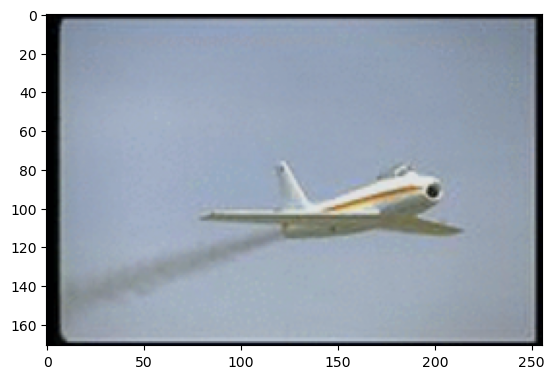

239.0625


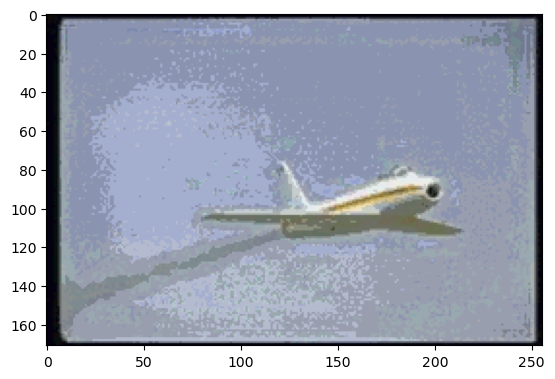

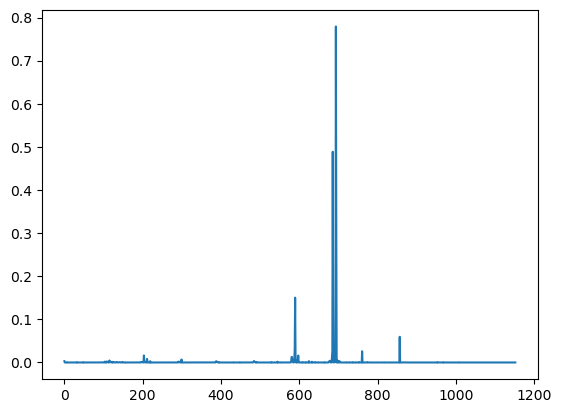

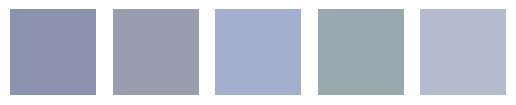

[(7, 2, 5), (7, 1, 5), (7, 2, 6), (6, 1, 5), (7, 1, 6)]


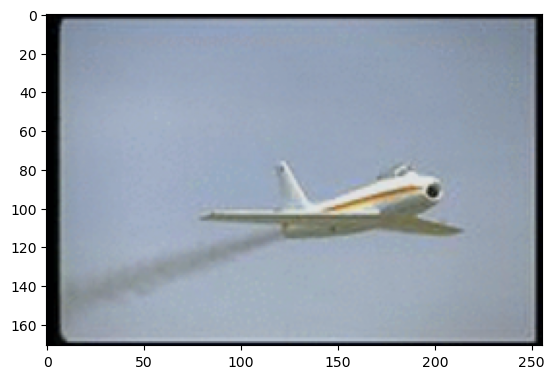

235.875


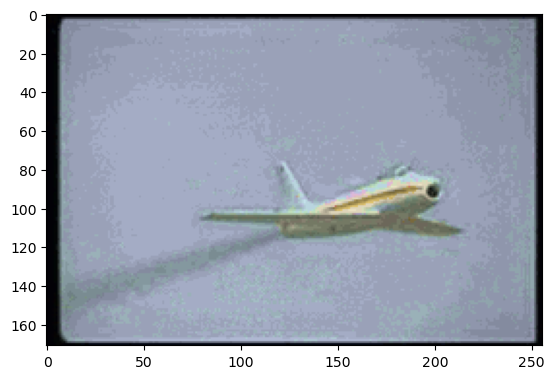

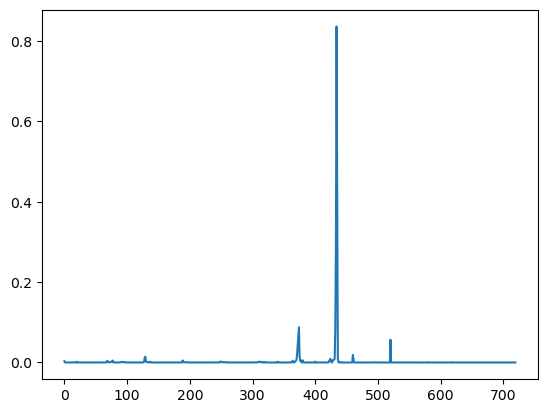

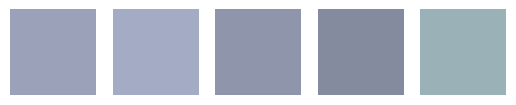

[(7, 0, 14), (7, 0, 15), (7, 0, 13), (7, 0, 12), (6, 0, 14)]


In [7]:
# Testing
PathImage = './Base/'
nom = 'Paysages67.png'

nH = 3
nS = 3
nV = 8
result = process_image(PathImage, nom, nH, nS, nV)
print(result)

nH = 12
nS = 3
nV = 3
result = process_image(PathImage, nom, nH, nS, nV)
print(result)

nH = 12
nS = 12
nV = 8
result = process_image(PathImage, nom, nH, nS, nV)
print(result)

nH = 12
nS = 3
nV = 20
result = process_image(PathImage, nom, nH, nS, nV)
print(result)

# ----------------

# Testing
PathImage = './Base/'
nom = 'Avions20.png'

nH = 3
nS = 3
nV = 8
result = process_image(PathImage, nom, nH, nS, nV)
print(result)

nH = 12
nS = 3
nV = 3
result = process_image(PathImage, nom, nH, nS, nV)
print(result)

nH = 12
nS = 12
nV = 8
result = process_image(PathImage, nom, nH, nS, nV)
print(result)

nH = 12
nS = 3
nV = 20
result = process_image(PathImage, nom, nH, nS, nV)
print(result)


6) What can you say about the results?

By adjusting the parameters nH, nS, and nV, we notice a consistent pattern where histograms exhibit peaks in similar locations. However, a notable variation in these parameters can influence the peak heights. Moreover, opting for larger values of nH, nS, or nV introduces multiple small peaks in specific regions, while smaller values result in fewer peaks concentrated at a single point in the histogram. This relationship aligns with the logical interpretation that nH, nS, and nV signify the number of intervals for H, S, and V values. Furthermore, choosing extremely low values can greatly distort the image, as illustrated in the first avion20 example. Hence, cautious parameter selection is imperative, as overly low values lead to a substantial loss of information about the observed image. On the other side, excessively high values have minimal impact on the image but may compromise subsequent processes. This is because an overly precise algorithm may struggle to identify similarities between images when confronted with highly detailed values. Overall we can say we need a balance in parameter selection for achieving a meaningful analysis without compromising the integrity of the image data.

## Exercise 2: Similarity between images: 

In this exercise, we will compute a measure of similarity between two images from the normalized histogram. This measure of similarity will be used in order to find images that are the most similar to a given image.

### Question 2.1:  Computation of the histograms for the whole base

Complete the following script to compute the histograms for every image in the base. As the computation can take a lot of time, we will do it only one time and store the result in ```ListHisto.mat```. The results will be stored as a ```N x M``` array ```listHisto``` with ```N = 1040``` and ```M = nH x nS x nV ```. We will also save the names of the images as ```listImage```

Set ```bcomputed = False``` for the first run to compute the database histograms and then set it to 1.


In [8]:
import os
from scipy.io.matlab.mio import loadmat, savemat

pathImage = './Base/'
pathDescriptors = './'

# Quantization HSV
nH = 12
nS = 3
nV = 8

bcomputed = True # Set to False to compute the histogramm database

if not bcomputed:
    listImage = os.listdir(pathImage)
    listHisto = []
    print('Histogram database computation ... it may take a while ...')
    for imageName in listImage:
        if os.path.isfile(pathImage+imageName) and imageName[-4:] == '.png':
            print( imageName)
            # read image
            I = np.array(Image.open(pathImage+imageName)) / 255.

            # conversion RGB->HSV
            J = rgb2hsv(I);
            # Image quantization (your function tested in Exo 1)
            _,histo = quantizeImage(J, nH, nS, nV)
  
            # flat a 3D histogram in 1D
            histo = histo.flatten()
            
            # Normalize histogramme (your function tested in Exo 1)
            listHisto.append(normalize(histo))

    print(len(listHisto), "histograms computed")
    nomList = pathDescriptors + 'ListHisto.mat'
    savemat(nomList, {'listHisto': np.array(listHisto),
                      'listImage': np.array(listImage)})
else:
    print("Histogram database computation already done.")

Histogram database computation already done.


C:\Users\conmy\AppData\Local\Temp\ipykernel_44272\1247958650.py:2: DeprecationWarning: Please use `loadmat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat
C:\Users\conmy\AppData\Local\Temp\ipykernel_44272\1247958650.py:2: DeprecationWarning: Please use `savemat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat


### Question 2.2: Computation of the similarity between every image in the base.

   1. Write a function ```similarityMatrix()``` or a script that performs the similarity computation for every pair of images in the base from the histograms stored in ```listHisto``` and store the result in a ```1024 x 1024``` matrix ```S```. It is possible to make the operation much faster by using only one matrix operation.

In [9]:
mat = loadmat(pathDescriptors+'ListHisto.mat')
listHisto = mat['listHisto']
listImage = mat['listImage']

def similarityMatrix(listHisto):
    S = np.zeros((1040,1040))
    for i in range(len(listHisto)):
        for j in range(len(listHisto)):
            S[i,j]=np.linalg.norm(listHisto[i]-listHisto[j])
    return S

S = similarityMatrix(listHisto)

2. Display the matrix `S`  as an image. What can we say about this it ?

The graph is symmetrical, since comparing the first image with the second is the same as comparing the second to the first. Also, there is a black diagonal line which corresponds to comparing one image with itself, since the distance from each image and itself is zero. Finally, the black squares correspond to groups of images that are arranger together in the database. The black squares far away from the line correspond to the drawback of this method, which is confusing some groups of images with some others.

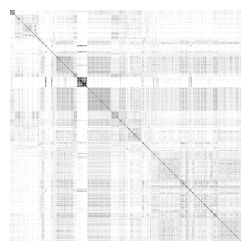

In [10]:
imshow(S)

3. Assuming `S` is already computed and using function `display20bestMatches()`, test on the image `Liontigre1.png` (indexQuery = 349). You should obtain something similar to Figure 5.

![figure5.png](./figs/Figure_5.png)
<center>Figure 5: 20 best matches of image 'Liontigre1.png'</center>

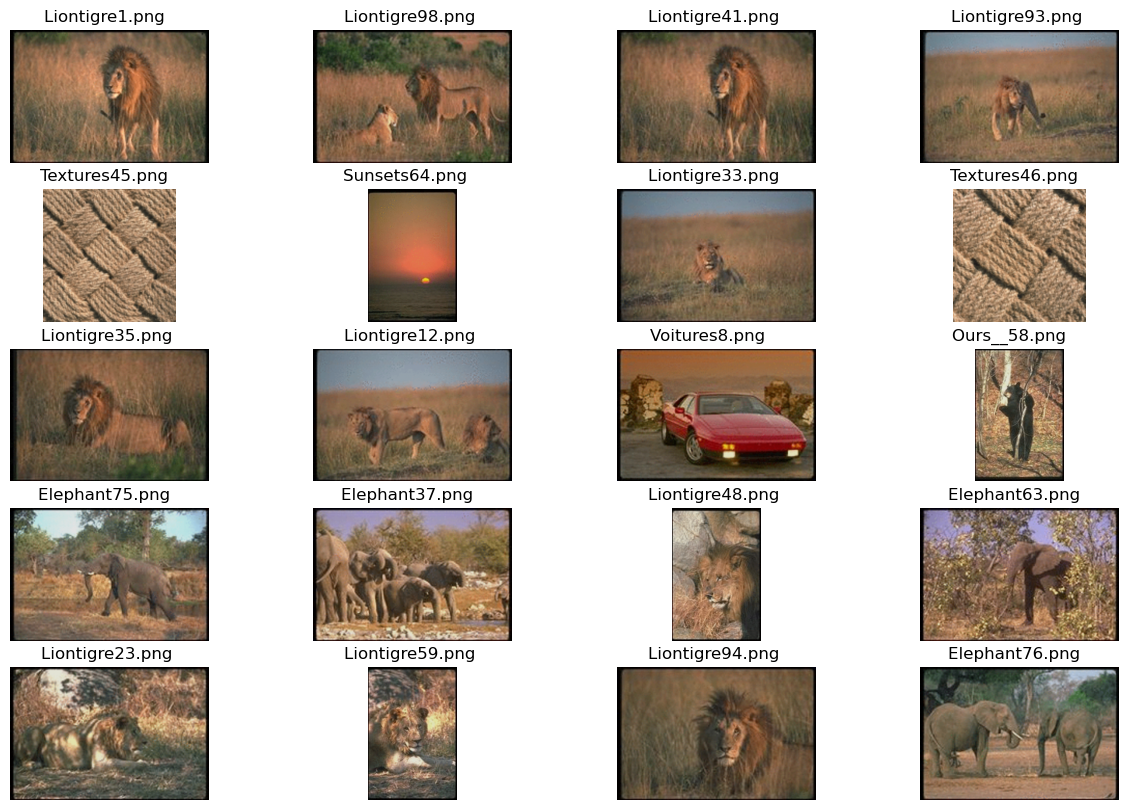

In [11]:
indexQuery = 349
display20bestMatches(S, indexQuery)
imageName = (pathImage+listImage[indexQuery]).strip()

4. Assuming `S` is already computed, generate a random query (an integer in the range $[0, 1030]$), and display the 20 best matches.


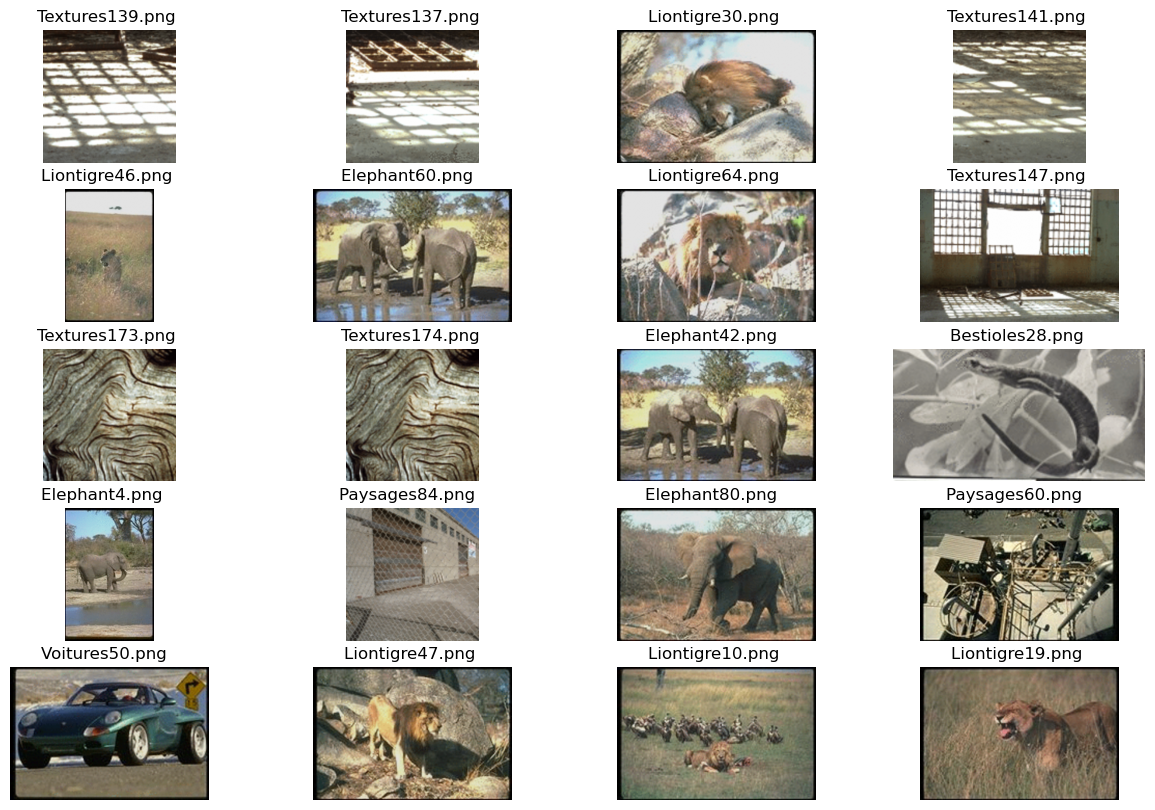

In [12]:
import random

display20bestMatches(S, random.randint(0,1039))
imageName = (pathImage+listImage[indexQuery]).strip()

5. What can you say about the results? What are the limitations and the advantages of this method?

This approach performs effectively with highly similar images, as shown in the lion image example in question 3. In this instance, a significant portion of the retrieved similar images are indeed lions. However, a notable drawback of this method is its exclusive consideration of pixel colors, disregarding their spatial positions within the image. Consequently, even if two images represent entirely different subjects, the method deems them similar if their colors closely match. In question 4 for example, the method perceives the images as similar, since the color of the elephants and some buildings are kind of similar, but the images themselves are actually not.